# 6.27 - Regularization Frob norm


TODO..

## 1. Setup Data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_circles


from sklearn.model_selection import train_test_split

np.random.seed(seed=1)

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, 
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

idx_class_0 = y == 0 
idx_class_1 = y == 1 

y_train_labels = np.zeros((y_train.size, 2)) 
y_train_labels[y_train == 1, 1] = 1
y_train_labels[y_train == 0, 0] = 1


y_test_labels = np.zeros((y_test.size, 2)) 
y_test_labels[y_test == 1, 1] = 1
y_test_labels[y_test == 0, 0] = 1

print("X_train:", X_train.shape)
print("y_train shape:", y_train_labels.shape)
print("X_test:", X_test.shape)
print("y_test shape:", y_test_labels.shape)

X_train: (75, 2)
y_train shape: (75, 2)
X_test: (25, 2)
y_test shape: (25, 2)


### 1.1 Plot the data

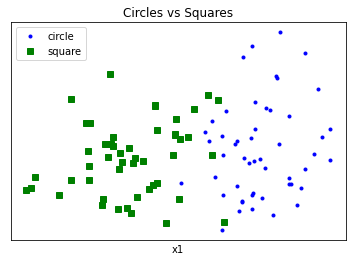

In [25]:
plt.plot(X[idx_class_0, 0], X[idx_class_0, 1], 'b.', label="circle")
plt.plot(X[idx_class_1, 0], X[idx_class_1, 1], 'gs', label="square")
plt.gca().axes.get_yaxis().set_visible(False)

plt.title("Circles vs Squares")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## 2. Fit a Model

In [26]:
def plot_loss(training_loss, validation_loss, sub_title):
    plt.plot(training_loss, label='training')
    plt.plot(validation_loss, label='test')
    plt.title(f"Error ({sub_title}) - last val loss: {validation_loss[-1]:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xlim(0, len(training_loss))
    plt.show()

In [27]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def output_layer_activation(A1, Theta_2, b2):
    return softmax((A1 @ Theta_2) + b2)

def hidden_layer_activation(X, Theta_1, b1):
    return sigmoid((X @ Theta_1) + b1)

def forward_pass(X, Theta_1, b1, Theta_2, b2):
    A1 = hidden_layer_activation(X, Theta_1, b1)
    A2 = output_layer_activation(A1, Theta_2, b2)
    return (A1, A2)

def cross_entropy_loss(Y_hat, Y):
    loss = - (Y * np.log(Y_hat)).sum() / Y.shape[0] 
    return loss

def get_output_error(Y_hat, Y):
    return Y_hat - Y

def get_hidden_layer_error(A1, Theta_2, Delta_3):
    return np.multiply(np.multiply(A1,(1 - A1)), (Delta_3 @ Theta_2.T))

def get_output_gradient(A1, Delta_3):
    return  A1.T @ Delta_3

def get_output_bias_gradient(Delta_3):
    return np.sum(Delta_3, axis=0, keepdims=True)

def get_hidden_gradient(X, Delta_2):
    return X.T @ Delta_2

def get_hidden_bias_gradient(Delta_2):
    return np.sum(Delta_2, axis=0, keepdims=True)

def calculate_gradients(X, Y, A1, A2, params):

    Theta_1, b1, Theta_2, b2 = params

    # Calculate Error 
    Delta_3 = get_output_error(A2, Y)
    Delta_2 = get_hidden_layer_error(A1, Theta_2, Delta_3)
    
    # Calculate Output Gradients
    JTheta_2 = get_output_gradient(A1, Delta_3)
    Jb2 = get_output_bias_gradient(Delta_3)
    
    # Calculate Hidden Layer Gradients
    JTheta_1 = get_hidden_gradient(X, Delta_2)
    
    Jb1 = get_hidden_bias_gradient(Delta_2)

    return [JTheta_1, Jb1, JTheta_2, Jb2]

def evaluate_validation_loss(X, y, params):
    Theta_1, b1, Theta_2, b2 = params
    _, yhat = forward_pass(X, Theta_1, b1, Theta_2, b2)
    return cross_entropy_loss(yhat, y)

def get_new_parameters(Js, params, learning_rate):    
    
    return [
    params[0] - (learning_rate * Js[0]),
    params[1] - (learning_rate * Js[1]),
    params[2] - (learning_rate * Js[2]),
    params[3] - (learning_rate * Js[3]) ]


### 2.1  Initialize parameters

In [28]:
learning_rate = 0.01
MAX_EPOCHS = 1200

o_b1 = np.random.randn(1, 5) 
o_Theta_1 = np.random.randn(2, 5)
o_b2 = np.random.randn(1, 2)
o_Theta_2 = np.random.randn(5, 2)


### 2.2 Batch GD - no regularization

In [29]:
b_b1 = np.copy(o_b1)
b_b2 = np.copy(o_b2)
b_Theta_1 = np.copy(o_Theta_1)
b_Theta_2 = np.copy(o_Theta_2)    

training_loss = []
validation_loss = []
    
for i in range(0, MAX_EPOCHS):
    
    ## 1. Forward Pass
    A1, A2 = forward_pass(X_train, b_Theta_1, b_b1, b_Theta_2, b_b2)
    
    ## 2. Training Loss
    t_loss = cross_entropy_loss(A2, y_train_labels)
    training_loss.append(t_loss)
    
    # 3. Calculate Gradient
    params = (b_Theta_1, b_b1, b_Theta_2, b_b2)
    Js = calculate_gradients(X_train, y_train_labels, A1, A2, params)

    ## 4. Evaluate on validation set    
    v_loss = evaluate_validation_loss(X_test, y_test_labels, params)
    validation_loss.append(v_loss)

    ## 5. Update Weights
    b_Theta_1, b_b1, b_Theta_2, b_b2 = get_new_parameters(Js, params, learning_rate)
    

In [30]:
def accuracy(y, yhat):
    return np.mean((yhat == y))

def predict_labels(X, params):
    
    Theta_1, b1, Theta_2, b2 = params
    _, yhat = forward_pass(X, Theta_1, b1, Theta_2, b2)

    tmp = yhat >= 0.5
    predicted_labels = np.copy(yhat)
    predicted_labels[tmp] = 1
    predicted_labels[~tmp] = 0

    return predicted_labels


### 2.3 Print model loss

In [31]:
predicted_labels = predict_labels(X_train, params)
print(f"Accuracy (train) {accuracy(y_train_labels, predicted_labels):.3f}")

predicted_labels_t = predict_labels(X_test, params)
print(f"Accuracy (test) {accuracy(y_test_labels, predicted_labels_t):.3f}")

Accuracy (train) 0.960
Accuracy (test) 0.960


### 2.4 Plot loss

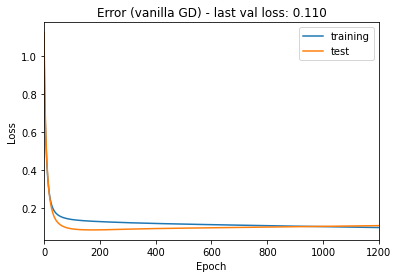

In [32]:
plot_loss(training_loss, validation_loss, "vanilla GD")

## 3. Try Regularisation (Frobenius Norm of weights)

### 3.1 Train with Regularisation

In [33]:

def cross_entropy_loss_with_regularization(lmbda, weights, Y_hat, Y):
    
    Theta_1, Theta_2 = weights
    
    m = Y_hat.shape[0]
    cross_entropy_loss = - (Y * np.log(Y_hat)).sum() / m
    penalty_term = (lmbda/m) * (np.sum(np.square(Theta_1)) + 
                                   np.sum(np.square(Theta_2)))
    
    #print(f"loss: {cross_entropy_loss + penalty_term}")
    return cross_entropy_loss + penalty_term

def calculate_gradients_with_regularization(lmbda, X, Y, A1, A2, params):

    Theta_1, b1, Theta_2, b2 = params

    m = Y.shape[0]
    
    # Calculate Error 
    Delta_3 = get_output_error(A2, Y)
    Delta_2 = get_hidden_layer_error(A1, Theta_2, Delta_3)
    
    # Calculate Output Gradients
    JTheta_2 = get_output_gradient(A1, Delta_3) + (lmbda * Theta_2)/m
    Jb2 = get_output_bias_gradient(Delta_3)
    
    # Calculate Hidden Layer Gradients
    JTheta_1 = get_hidden_gradient(X, Delta_2) + (lmbda * Theta_1)/m
    
    Jb1 = get_hidden_bias_gradient(Delta_2)

    return [JTheta_1, Jb1, JTheta_2, Jb2]


In [34]:
f_b1 = np.copy(o_b1)
f_b2 = np.copy(o_b2)
f_Theta_1 = np.copy(o_Theta_1)
f_Theta_2 = np.copy(o_Theta_2)    

training_loss = []
validation_loss = []

learning_rate = 0.01
lmbda = 0.01
    
for i in range(0, MAX_EPOCHS):
    
    ## 1. Forward Pass
    A1, A2 = forward_pass(X_train, f_Theta_1, f_b1, f_Theta_2, f_b2)
    
    ## 2. Training Loss
    t_loss = cross_entropy_loss_with_regularization(lmbda, (f_Theta_1, f_Theta_2), A2, y_train_labels)
    training_loss.append(t_loss)
    
    # 3. Calculate Gradient
    params = (f_Theta_1, f_b1, f_Theta_2, f_b2)
    Js = calculate_gradients_with_regularization(lmbda, X_train, y_train_labels, A1, A2, params)

    ## 4. Evaluate on validation set    
    v_loss = evaluate_validation_loss(X_test, y_test_labels, params)
    validation_loss.append(v_loss)

    ## 5. Update Weights
    f_Theta_1, f_b1, f_Theta_2, f_b2 = get_new_parameters(Js, params, learning_rate)
    

### 3.2 Print Accuracy

In [35]:
predicted_labels = predict_labels(X_train, params)
print(f"Accuracy (train) {accuracy(y_train_labels, predicted_labels):.3f}")

predicted_labels_t = predict_labels(X_test, params)
print(f"Accuracy (test) {accuracy(y_test_labels, predicted_labels_t):.3f}")

Accuracy (train) 0.960
Accuracy (test) 0.960


### 3.3 Plot loss

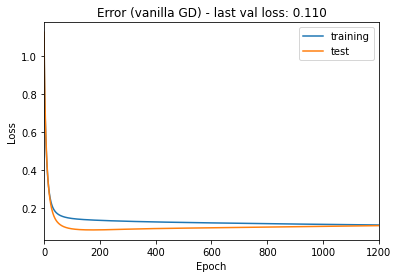

In [36]:
plot_loss(training_loss, validation_loss, "vanilla GD")

In [76]:
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

##
## Note: This is squashing warnings about convergence. 
## This is because we're constraining the training to a max number of iterations of 50.
## For development, you should remove this.
##

#warnings.filterwarnings("ignore", category=ConvergenceWarning) 
    
clf = MLPClassifier(solver = 'sgd', 
                    hidden_layer_sizes=(50, ),
                    momentum=0, 
                    alpha=0.1,
                    learning_rate = 'constant', 
                    random_state=1,
                    learning_rate_init = 0.01).fit(X_train, y_train)

print("Training set Accuracy Score: (sgd)", clf.score(X_train, y_train))
print("Validation set Accuracy Score: (sgd)", clf.score(X_test, y_test))

Training set Accuracy Score: (sgd) 0.9333333333333333
Validation set Accuracy Score: (sgd) 0.96


/Users/heather/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
